In [1]:
# Implementation an Email Spam Detection model using a Support Vector Machine (SVM) for
# binary classification, where emails are categorized as Normal (Not Spam) or Abnormal (Spam).
# Apply oversampling or undersampling techniques to handle class imbalance and analyze model
# performance using appropriate evaluation metrics.

In [2]:
import pandas as pd, numpy as np, csv, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)


In [3]:
# Robust load (works on all pandas versions)
try:
    df = pd.read_csv("emails.csv")
except Exception:
    with open("emails.csv","r",encoding="utf-8",errors="ignore") as f:
        rows=[r for r in csv.reader(f) if len(r)>1]
    df=pd.DataFrame(rows[1:],columns=rows[0])

y = pd.to_numeric(df["Prediction"], errors="coerce").fillna(0).astype(int)
X = df.drop(columns=["Prediction","Email No."], errors="ignore") \
       .apply(pd.to_numeric, errors="coerce").fillna(0)

# Split 75/25 stratified
X_train,X_test,y_train,y_test = train_test_split(
    X.values, y.values, test_size=0.25, random_state=42, stratify=y)
print("Before:", dict(zip(*np.unique(y_train, return_counts=True))))


Before: {0: 2754, 1: 1125}


In [4]:
# Simple random oversampling (manual, no imblearn needed)
maj, minc = np.bincount(y_train).argmax(), np.bincount(y_train).argmin()
maj_idx, min_idx = np.where(y_train==maj)[0], np.where(y_train==minc)[0]
reps = int(np.ceil(len(maj_idx)/len(min_idx)))
min_aug = np.tile(min_idx, reps)[:len(maj_idx)]
idx_new = np.concatenate([maj_idx, min_aug])
np.random.default_rng(42).shuffle(idx_new)

X_train_rs, y_train_rs = X_train[idx_new], y_train[idx_new]
print("After :", dict(zip(*np.unique(y_train_rs, return_counts=True))))


After : {0: 2754, 1: 2754}


c:\Users\Chinmaya Kolhe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Acc=0.959 Prec=0.899 Rec=0.968 F1=0.932 AUC=0.985
           Pred_Ham  Pred_Spam
True_Ham        877         41
True_Spam        12        363


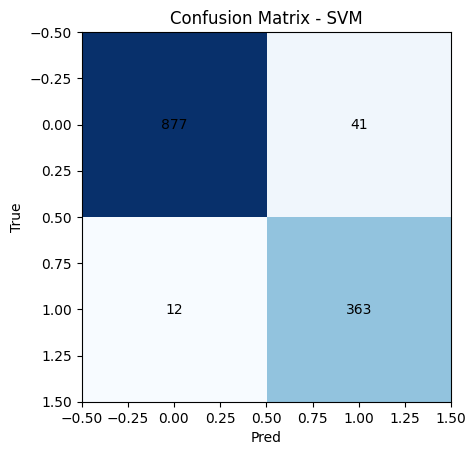

In [5]:
# Scale and train
scaler = MaxAbsScaler()
X_train_rs = scaler.fit_transform(X_train_rs)
X_test_sc  = scaler.transform(X_test)

clf = LinearSVC(C=1.0, random_state=42)
clf.fit(X_train_rs, y_train_rs)

# Predict + metrics
y_pred = clf.predict(X_test_sc)
scores = clf.decision_function(X_test_sc)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, scores)

print(f"Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f} AUC={auc:.3f}")
print(pd.DataFrame(cm, index=["True_Ham","True_Spam"], columns=["Pred_Ham","Pred_Spam"]))

plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix - SVM"); plt.xlabel("Pred"); plt.ylabel("True")
for i in range(2):
    for j in range(2): plt.text(j,i,cm[i,j],ha="center",va="center")
plt.show()
